In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.svm import SVR



Import data, and remove oddities such as , and . being switched, letter where numbers where expected, and convert everything to the right datatype

In [56]:
data=pd.read_csv("data.tab", sep='\t', header=None, names = ["id", "runday", "country", "date", "new_deaths_smoothed_per_million", "stringency_index", "median_age", "gdp_per_capita", "tour_inc_gdp", "civilliberties", "trustp", "icu_bed", "lr", "plurality", "oppfrac", "govfrac", "checks"])
# data = data.stack().str.replace(',','.').unstack()
# data.to_csv("data.csv")
# data.loc[data['country'] == "Portugal"].head()
# data = data.sort_values(["id","runday"], axis = 0, ascending = True)
# display(data.head(8))
for col in data.columns.drop(['country', 'date']):
    data[col] = data[col].astype("string").str.replace(',','.').str.replace(r'[^0-9_._e_-]+', '')
    # for value in col:
        # if value.astype("string") =
    # dfObject['C'] = dfObject['C'].str.replace(r'[^0-9]+', '')
data = data.replace('', np.NaN)

#leave the string collumns, then convert cols to int or float as needed.
for col in data.columns.drop(['country', 'date']):
    # display(col)
    if col in ['id', 'runday', 'civilliberties', 'plurality', 'checks']:
        data[col] = data[col].astype("int")
    else:
        data[col] = data[col].astype("float")
     # data[col] = data[col].astype("float")
data['country'] = data['country'].astype('string')

data = data.sort_values(["id","runday"], axis = 0, ascending = True)
data.head(8)



C:\Users\thijs\AppData\Local\Temp\ipykernel_21968\3860647068.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].astype("string").str.replace(',','.').str.replace(r'[^0-9_._e_-]+', '')


,id,runday,country,date,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,lr,plurality,oppfrac,govfrac,checks
395,1,56,Austria,25-2-2020,NaN,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0.595364,0,0.630643,0.396478,5
412,1,57,Austria,26-2-2020,NaN,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0.595364,0,0.630643,0.396478,5
429,1,58,Austria,27-2-2020,NaN,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0.595364,0,0.630643,0.396478,5
446,1,59,Austria,28-2-2020,NaN,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0.595364,0,0.630643,0.396478,5
463,1,60,Austria,29-2-2020,NaN,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0.595364,0,0.630643,0.396478,5
2,1,61,Austria,1-3-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0.595364,0,0.630643,0.396478,5
19,1,62,Austria,2-3-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0.595364,0,0.630643,0.396478,5
36,1,63,Austria,3-3-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0.595364,0,0.630643,0.396478,5


In [59]:
NaNs = pd.DataFrame()
for country in np.unique(data["country"]):
    # print(country)
    countryData = data.loc[data['country'] == country]
    
    # print(country, " has ", countryData.isna().sum(), " \n NaN values \n")

Austria  has  10  
 NaN values 

Belgium  has  10  
 NaN values 

Bulgaria  has  8  
 NaN values 

Croatia  has  6  
 NaN values 

Czech Republic  has  5  
 NaN values 

Denmark  has  30  
 NaN values 

Estonia  has  29  
 NaN values 

Finland  has  5  
 NaN values 

France  has  5  
 NaN values 

Germany  has  8  
 NaN values 

Greece  has  12  
 NaN values 

Hungary  has  6  
 NaN values 

Ireland  has  5  
 NaN values 

Italy  has  5  
 NaN values 

Latvia  has  14  
 NaN values 

Lithuania  has  5  
 NaN values 

Netherlands  has  5  
 NaN values 

Norway  has  6  
 NaN values 

Poland  has  5  
 NaN values 

Portugal  has  13  
 NaN values 

Romania  has  5  
 NaN values 

Slovakia  has  5  
 NaN values 

Slovenia  has  37  
 NaN values 

Spain  has  5  
 NaN values 

Sweden  has  5  
 NaN values 

Switzerland  has  5  
 NaN values 

United Kingdom  has  5  
 NaN values 



In [3]:
print(data.isna().sum())
# for col in data.columns:
    # data[col] = data[col].interpolate('bfill')
for col in data.columns:
    if col in ['country','date', 'plurality', 'lr']:
        data[col] = data[col].interpolate('ffill') #interpolate non-numeric cols with forward fill
    else:
        data[col] = data[col].interpolate('linear') #interpolate numeric cols with linear interpolation
        
data['new_deaths_smoothed_per_million'] = data['new_deaths_smoothed_per_million'].interpolate('bfill')#the first 5 days here are empty, so linear interpolation doesnt work, therefore we interpolate this colagain


print(data.isna().sum())


id                                   0
runday                               0
country                              0
date                                 0
new_deaths_smoothed_per_million    259
stringency_index                   197
median_age                           0
gdp_per_capita                       0
tour_inc_gdp                         0
civilliberties                       0
trustp                               0
icu_bed                              0
lr                                 502
plurality                            0
oppfrac                              0
govfrac                              0
checks                               0
dtype: int64
id                                 0
runday                             0
country                            0
date                               0
new_deaths_smoothed_per_million    0
stringency_index                   0
median_age                         0
gdp_per_capita                     0
tour_inc_gdp                

In [4]:
data.describe()
data.head()

,id,runday,country,date,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,lr,plurality,oppfrac,govfrac,checks
395,1,56,Austria,25-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0.595364,0,0.630643,0.396478,5
412,1,57,Austria,26-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0.595364,0,0.630643,0.396478,5
429,1,58,Austria,27-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0.595364,0,0.630643,0.396478,5
446,1,59,Austria,28-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0.595364,0,0.630643,0.396478,5
463,1,60,Austria,29-2-2020,0.0,11.11,44.4,45436.688,4.4,56,0.07892,1.541315,0.595364,0,0.630643,0.396478,5


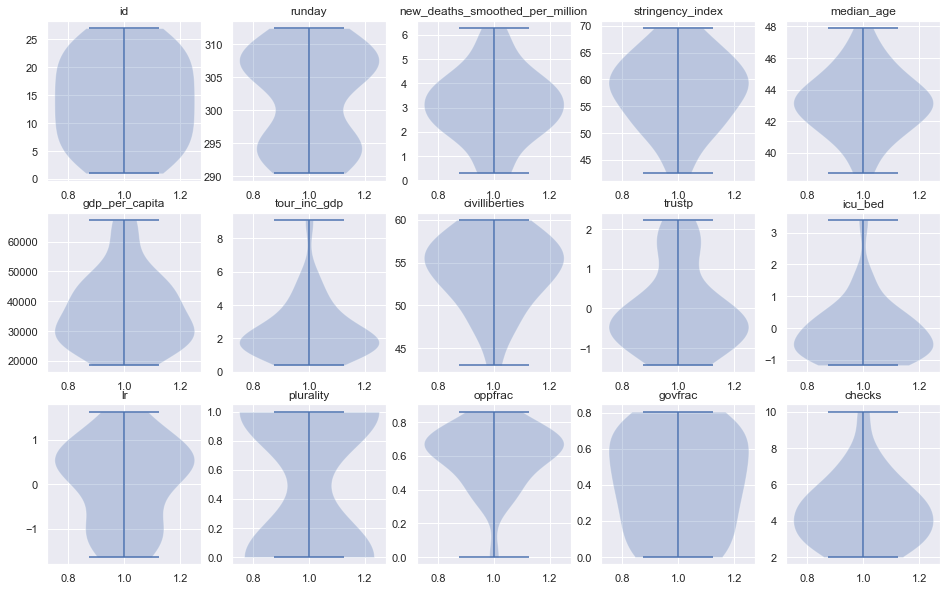

In [36]:
data_grouped = data.groupby("country")#.drop(['lr', 'plurality'], axis=1)
# display(data_grouped.mean())

plt.figure(figsize = (16,10))

for i,col in enumerate(data_grouped.mean(), 1):
    plt.subplot(3,5,i)
    plt.title(col)
    plt.violinplot(data_grouped.mean()[col])
    
plt.savefig('figures/violin.jpg', bbox_inches='tight')

In [45]:
countryData = data[data['country'] == "Belgium"]


# countryData.head()


countryData = countryData.drop(['country','date', 'plurality', 'lr'],axis=1).dropna()
countryData.head()
# sns.lineplot(x="runday", y="new_deaths_smoothed_per_million", data=data)


display(countryData.describe())


,id,runday,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,oppfrac,govfrac,checks
count,523.0,523.000000,523.000000,523.000000,5.230000e+02,5.230000e+02,5.230000e+02,523.0,5.230000e+02,5.230000e+02,5.230000e+02,5.230000e+02,523.0
mean,2.0,296.000000,4.157551,57.174302,4.180000e+01,4.265857e+04,1.400000e+00,57.0,7.891954e-02,6.319202e-01,8.618726e-01,6.827881e-01,7.0
std,0.0,151.121364,5.596636,16.351539,4.053971e-13,1.019609e-10,1.711380e-14,0.0,5.695340e-16,3.556115e-15,1.055722e-14,1.778058e-15,0.0
min,2.0,35.000000,-1.245000,11.110000,4.180000e+01,4.265857e+04,1.400000e+00,57.0,7.891954e-02,6.319202e-01,8.618726e-01,6.827881e-01,7.0
25%,2.0,165.500000,0.419000,50.930000,4.180000e+01,4.265857e+04,1.400000e+00,57.0,7.891954e-02,6.319202e-01,8.618726e-01,6.827881e-01,7.0
50%,2.0,296.000000,2.293000,60.190000,4.180000e+01,4.265857e+04,1.400000e+00,57.0,7.891954e-02,6.319202e-01,8.618726e-01,6.827881e-01,7.0
75%,2.0,426.500000,4.493000,63.890000,4.180000e+01,4.265857e+04,1.400000e+00,57.0,7.891954e-02,6.319202e-01,8.618726e-01,6.827881e-01,7.0
max,2.0,557.000000,28.770000,81.480000,4.180000e+01,4.265857e+04,1.400000e+00,57.0,7.891954e-02,6.319202e-01,8.618726e-01,6.827881e-01,7.0


In [46]:
display(countryData.dtypes)
countryData.isnull().values.any()

id                                   int32
runday                               int32
new_deaths_smoothed_per_million    float64
stringency_index                   float64
median_age                         float64
gdp_per_capita                     float64
tour_inc_gdp                       float64
civilliberties                       int32
trustp                             float64
icu_bed                            float64
oppfrac                            float64
govfrac                            float64
checks                               int32
dtype: object

False

In [47]:
def absolute_maximum_scale(x):
    # return series / series.abs().max()
    if x.max() == 0:
        x_norm = x
    else:
        x_norm = x / x.max(axis=0)
    return x_norm

countryData_normalised = pd.DataFrame()
for col in countryData.columns:#.drop(['country']):
    countryData_normalised[col] = absolute_maximum_scale(countryData[col])

# countryData_normalised = pd.DataFrame(preprocessing.normalize(countryData, axis=0),columns=names)

countryData_normalised.head()
# countryData_normalised.dropna().isnull().values.any()

,id,runday,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,oppfrac,govfrac,checks
554,1.0,0.062837,0.006430,0.136352,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
572,1.0,0.064632,0.005144,0.136352,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
590,1.0,0.066427,0.003858,0.136352,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
608,1.0,0.068223,0.002572,0.136352,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
626,1.0,0.070018,0.001286,0.136352,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [48]:
pca = PCA(n_components = 2)
pca.fit(countryData_normalised)
countryData_transformed = pca.transform(countryData)
display(pca.explained_variance_ratio_, pca.explained_variance_)

loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=countryData_normalised.columns)
display(loadings)

array([0.49552593, 0.39189994])

array([0.07518413, 0.05946138])

,PC1,PC2
id,1.110223e-16,1.387779e-16
runday,-9.863519e-01,6.567734e-03
new_deaths_smoothed_per_million,1.243569e-01,6.846013e-01
stringency_index,-1.079134e-01,7.288881e-01
median_age,-0.000000e+00,-0.000000e+00
gdp_per_capita,-0.000000e+00,-0.000000e+00
tour_inc_gdp,-0.000000e+00,-0.000000e+00
civilliberties,-0.000000e+00,-0.000000e+00
trustp,-0.000000e+00,-0.000000e+00
icu_bed,-0.000000e+00,-0.000000e+00


Text(0, 0.5, 'Second Principal Component')

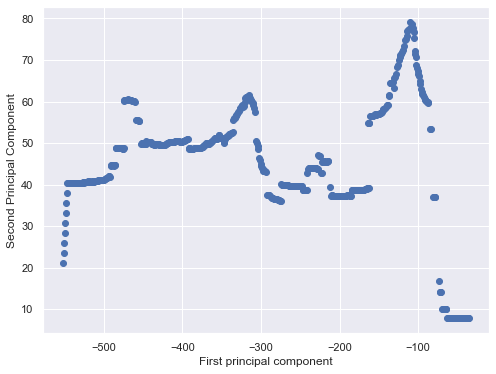

In [49]:
plt.figure(figsize=(8,6))
plt.scatter(countryData_transformed[:,0],countryData_transformed[:,1])
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')


In [50]:
display(countryData.loc[(countryData['stringency_index']<60) & (countryData['runday']>200)])

,id,runday,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,oppfrac,govfrac,checks
826,2,201,0.2220,50.000000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
843,2,202,0.2840,50.000000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
860,2,203,0.2655,50.000000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
877,2,204,0.2470,50.000000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
894,2,205,0.2100,50.000000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,2,553,0.2960,37.761111,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
619,2,554,0.2840,34.468889,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
637,2,555,0.1970,31.176667,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
655,2,556,0.1600,27.884444,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7


In [13]:
display(countryData.loc[(countryData['stringency_index']<30)])

,id,runday,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,oppfrac,govfrac,checks
554,2,35,0.185,11.110000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
572,2,36,0.148,11.110000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
590,2,37,0.111,11.110000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
608,2,38,0.074,11.110000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
626,2,39,0.037,11.110000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
644,2,40,0.000,11.110000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
662,2,41,0.000,11.110000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
680,2,42,0.000,11.110000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
697,2,43,0.000,11.110000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7
714,2,44,0.000,11.110000,41.8,42658.574,1.4,57,0.07892,0.63192,0.861873,0.682788,7


C:\Users\thijs\AppData\Local\Temp\ipykernel_21968\3632905200.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(points, ax=axes.ravel().tolist())


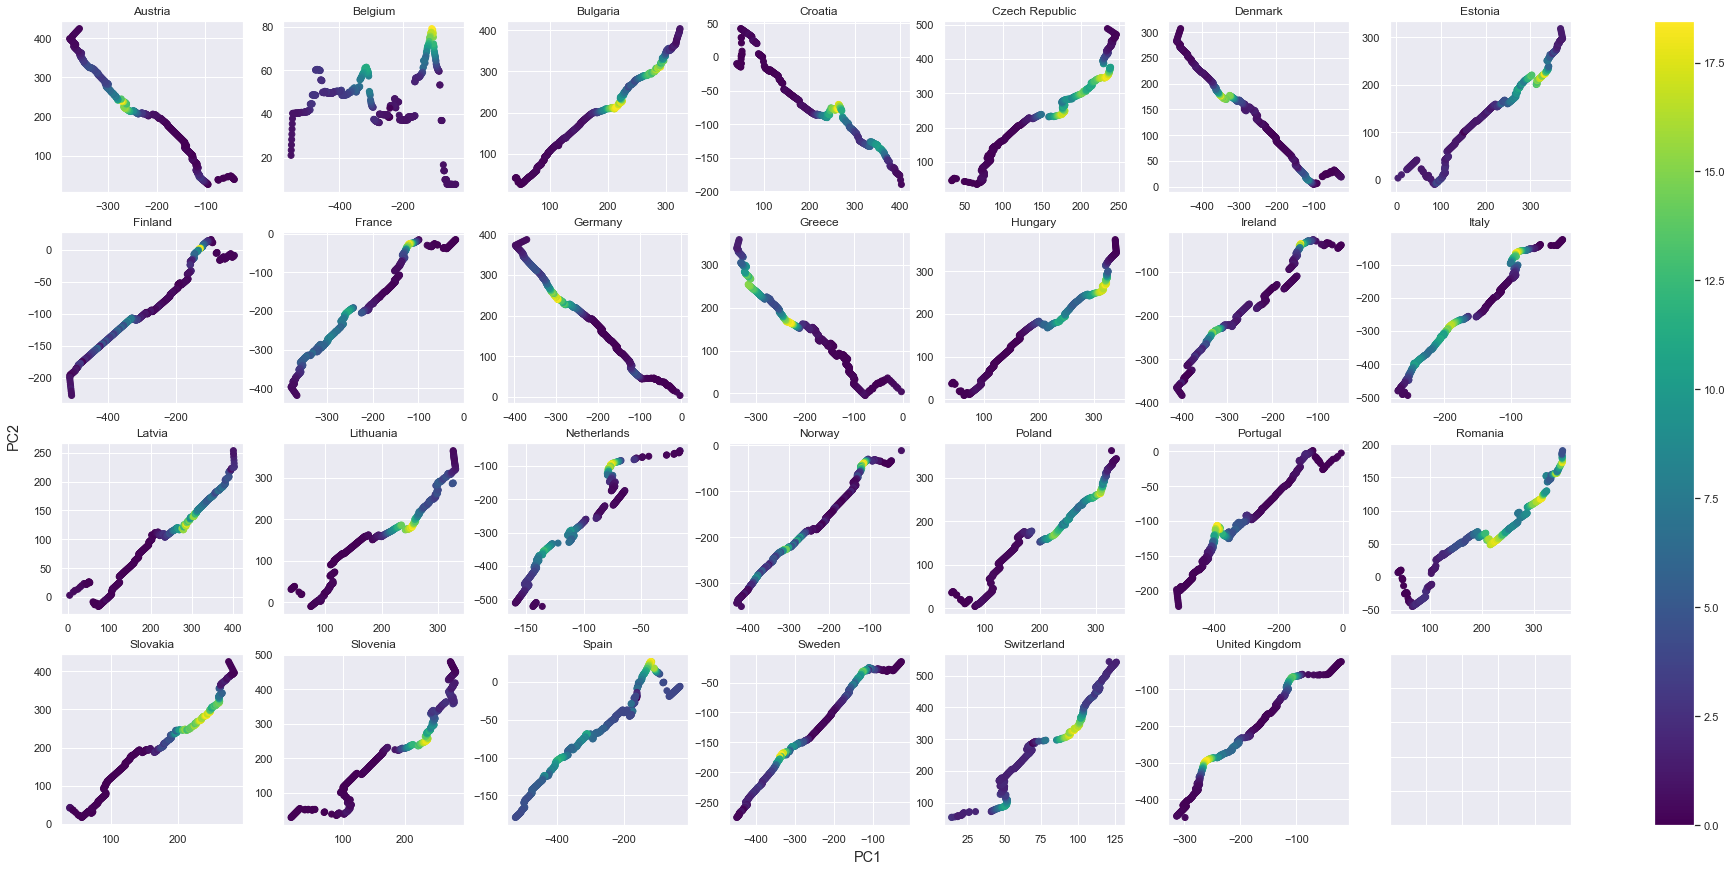

In [52]:

# plt.figure(figsize = (30,40))
fig, axes = plt.subplots(nrows=4, ncols=7, figsize = (24,12), constrained_layout=True)
for i, country in enumerate(np.unique(data["country"])):
    # print(country)
    countryData = data.loc[data['country'] == country]
    countryData = countryData.drop(['country', 'date', 'plurality', 'lr'],axis=1).dropna()
    
    countryData_normalised = pd.DataFrame()
    for col in countryData.columns:
        countryData_normalised[col] = absolute_maximum_scale(countryData[col].astype(float))

    pca = PCA(n_components = 2)
    pca.fit(countryData_normalised)
    countryData_transformed = pca.transform(countryData)
    
    # plt.subplot(5,6,i)
    # plt.figure(figsize=(8,6))
    ax = axes.flat[i]
    coloring = np.array(countryData['new_deaths_smoothed_per_million']).reshape(countryData['new_deaths_smoothed_per_million'].size,1)
    countryData_transformed = np.append(countryData_transformed, coloring, axis=1)
    points = ax.scatter(countryData_transformed[:,0], countryData_transformed[:,1], c=coloring, cmap='viridis')
    # fg = sns.FacetGrid(data=countryData_transformed, hue='Gender', hue_order=_genders)
    ax.title.set_text(country)
fig.supxlabel('PC1')
fig.supylabel('PC2')
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.colorbar(points, ax=axes.ravel().tolist())
plt.savefig('figures/combinedPCA.jpg', bbox_inches='tight')

In [15]:
data.head()
data_normalised = pd.DataFrame()
for col in data.columns:
    if col in data.drop(['country', 'date', 'plurality'],axis=1):
        data_normalised[col] = absolute_maximum_scale(data[col])
    else:
        data_normalised[col] = data[col]
        
data_normalised

,id,runday,country,date,new_deaths_smoothed_per_million,stringency_index,median_age,gdp_per_capita,tour_inc_gdp,civilliberties,trustp,icu_bed,lr,plurality,oppfrac,govfrac,checks
395,0.037037,0.100539,Austria,25-2-2020,0.000000,0.115369,0.926931,0.674783,0.483517,0.933333,0.035336,0.452484,0.365451,0,0.731713,0.492369,0.5
412,0.037037,0.102334,Austria,26-2-2020,0.000000,0.115369,0.926931,0.674783,0.483517,0.933333,0.035336,0.452484,0.365451,0,0.731713,0.492369,0.5
429,0.037037,0.104129,Austria,27-2-2020,0.000000,0.115369,0.926931,0.674783,0.483517,0.933333,0.035336,0.452484,0.365451,0,0.731713,0.492369,0.5
446,0.037037,0.105925,Austria,28-2-2020,0.000000,0.115369,0.926931,0.674783,0.483517,0.933333,0.035336,0.452484,0.365451,0,0.731713,0.492369,0.5
463,0.037037,0.107720,Austria,29-2-2020,0.000000,0.115369,0.926931,0.674783,0.483517,0.933333,0.035336,0.452484,0.365451,0,0.731713,0.492369,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12337,1.000000,0.992819,Sweden,6-7-2021,0.003441,0.538422,0.855950,0.697246,0.285714,1.000000,0.662368,-0.271505,-0.735893,0,0.921898,0.297897,0.4
12355,1.000000,0.994614,Sweden,7-7-2021,0.004901,0.538422,0.855950,0.697246,0.285714,1.000000,0.662368,-0.271505,-0.735893,0,0.921898,0.297897,0.4
12373,1.000000,0.996409,Sweden,8-7-2021,0.005909,0.538422,0.855950,0.697246,0.285714,1.000000,0.662368,-0.271505,-0.735893,0,0.921898,0.297897,0.4
12391,1.000000,0.998205,Sweden,9-7-2021,0.005909,0.538422,0.855950,0.697246,0.285714,1.000000,0.662368,-0.271505,-0.735893,0,0.921898,0.297897,0.4


In [16]:
data.isnull().values.any()
print(data.isna().sum()) 

id                                 0
runday                             0
country                            0
date                               0
new_deaths_smoothed_per_million    0
stringency_index                   0
median_age                         0
gdp_per_capita                     0
tour_inc_gdp                       0
civilliberties                     0
trustp                             0
icu_bed                            0
lr                                 0
plurality                          0
oppfrac                            0
govfrac                            0
checks                             0
dtype: int64


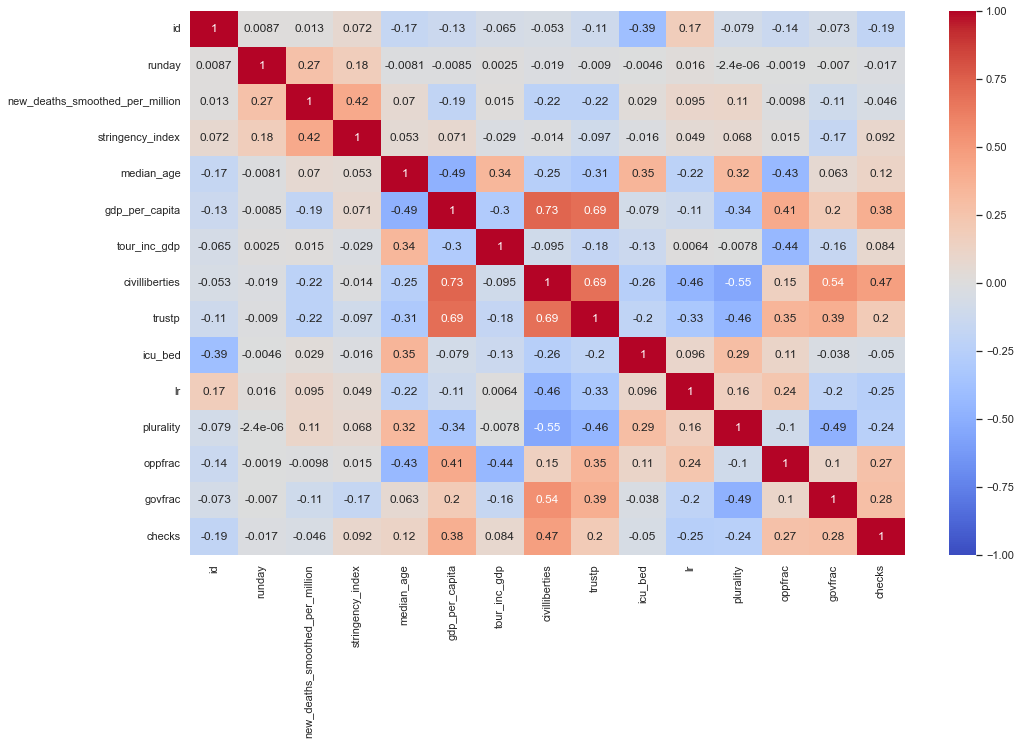

In [37]:
sns.set(rc = {'figure.figsize':(16, 10)})
dataplot = sns.heatmap(data.corr(), cmap="coolwarm", annot=True, vmin=-1, vmax=1)
plt.savefig('figures/correlations.jpg', bbox_inches='tight')

Linear regression to predict deaths per day per million

In [17]:

X = data_normalised.drop(['country', 'date', 'plurality', 'new_deaths_smoothed_per_million'],axis=1)
y = data_normalised['new_deaths_smoothed_per_million']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, shuffle=True)


model = LinearRegression().fit(X_train, y_train)
score = model.score(X_test, y_test)
score2 = mean_squared_error(model.predict(X_test), y_test)
display(score)


# plt.figure()
# plt.scatter(model.predict(X_test), y_test, alpha = 0.4)
# plt.xlabel('prections')
# plt.ylabel('data')
# display(model.())

0.2889813256615871

In [18]:
#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=20, n_repeats=3)

#define model
lassoModel = LassoCV(alphas=np.arange(0.001, 1, 0.01), cv=cv, n_jobs=-1)

#fit model
lassoModel.fit(X_train, y_train)

lassoScore = lassoModel.score(X_test, y_test)
lassoScore2 = mean_squared_error(lassoModel.predict(X_test), y_test)
print("alpha: ", lassoModel.alpha_, " score: ", lassoScore)

# plt.scatter(lassoModel.predict(X_test), y_test, alpha = 0.4)
# plt.xlabel('prections')
# plt.ylabel('data')

alpha:  0.001  score:  0.27454894294227383


In [19]:
#define cross-validation method to evaluate model
# cv = RepeatedKFold(n_splits=12, n_repeats=3, random_state=1)

#define model
ridgeModel = RidgeCV(alphas=np.arange(0.01, 1, 0.01), cv=cv)

#fit model
ridgeModel.fit(X_train, y_train)

ridgeScore = ridgeModel.score(X_test, y_test)
ridgeScore2 = mean_squared_error(ridgeModel.predict(X_test), y_test)
#display lambda that produced the lowest test MSE
print("alpha: ", ridgeModel.alpha_, " score: ", ridgeScore)

# plt.scatter(ridgeModel.predict(X_test), y_test, alpha = 0.4)
# plt.xlabel('prections')
# plt.ylabel('data')

alpha:  0.21000000000000002  score:  0.2890133329082428


In [20]:
SVRModel = SVR(kernel='rbf')
SVRModel.fit(X_train,y_train)

SVRScore = SVRModel.score(X_test, y_test)
SVRScore2 = mean_squared_error(SVRModel.predict(X_test), y_test)
#display lambda that produced the lowest test MSE
print("score: ", SVRScore, SVRScore2)

# plt.scatter(SVRModel.predict(X_test), y_test, alpha = 0.4)
# plt.xlabel('prections')
# plt.ylabel('data')

score:  0.62159034370203 0.009254378262612389


In [21]:
coefficients = pd.DataFrame(np.stack((model.coef_, lassoModel.coef_, ridgeModel.coef_), axis = 0).T, columns=['linear', 'lasso', 'ridge'], index=X.columns)
scores = [score, lassoScore, ridgeScore, SVRScore]
scores2 = [score2, lassoScore2, ridgeScore2, SVRScore2]

scoreDF = pd.DataFrame(np.stack([scores,scores2]).T, index=['linear', 'lasso', 'ridge', 'svr'], columns = ["scores",'MSE'])
display(coefficients, scoreDF)

,linear,lasso,ridge
id,-0.024408,-0.009695,-0.024573
runday,0.110668,0.102531,0.110718
stringency_index,0.329665,0.282521,0.329083
median_age,-0.330176,-0.000000,-0.318316
gdp_per_capita,-0.112435,-0.116348,-0.113360
tour_inc_gdp,0.019652,-0.000000,0.018923
civilliberties,-0.437675,-0.000000,-0.425995
trustp,-0.023998,-0.031437,-0.024340
icu_bed,-0.007142,-0.000000,-0.007556
lr,-0.018526,0.000077,-0.018049


,scores,MSE
linear,0.288981,0.017389
lasso,0.274549,0.017742
ridge,0.289013,0.017388
svr,0.621590,0.009254


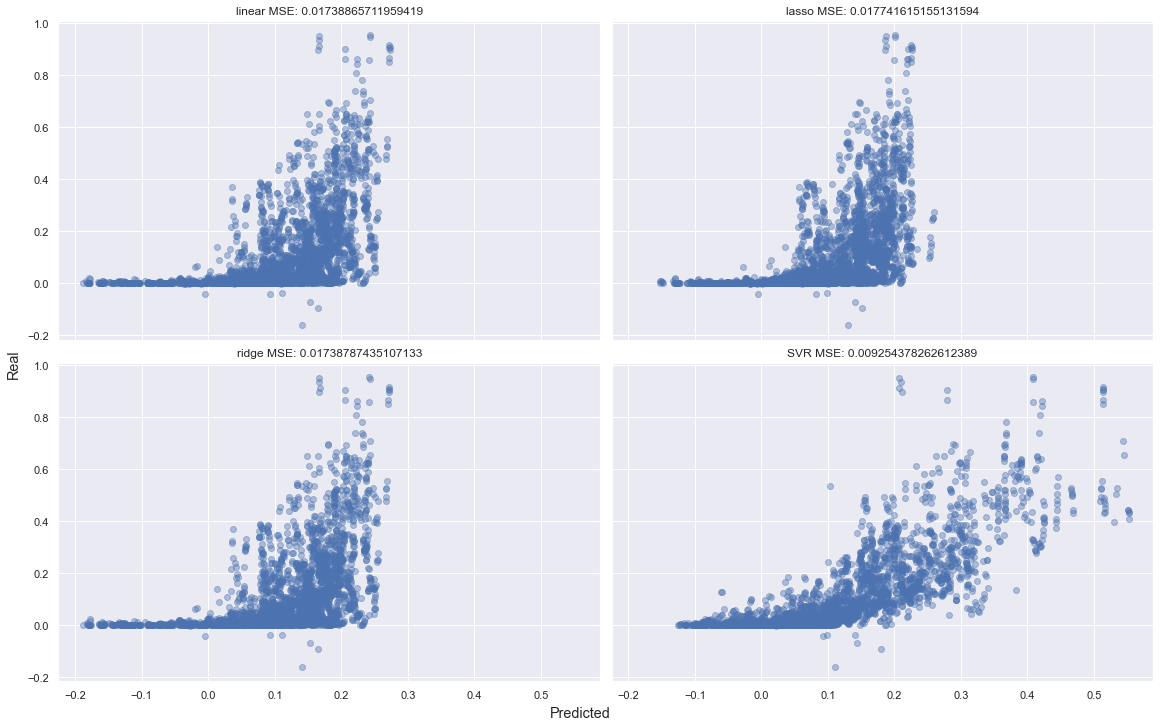

In [30]:
models = [model, lassoModel, ridgeModel, SVRModel]
modelNames = ['linear', 'lasso', 'ridge', 'SVR']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (16,10),constrained_layout=True,sharex=True, sharey=True)
for i, regModel in enumerate(models):
    ax = axes.flat[i]
    ax.scatter(regModel.predict(X_test), y_test, alpha = 0.4, cmap='viridis')
    ax.title.set_text(modelNames[i] + ' MSE: ' + str(scores2[i]))
    # plt.xlabel('prections')
    # plt.ylabel('data')
fig.supxlabel('Predicted')
fig.supylabel('Real')
plt.savefig('figures/realVsPredicted.jpg', bbox_inches='tight')